In [51]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import copy

In [52]:
root = 'D:\MY PROJECTS\project\-Monkeypox-Detection-master (2)\-Monkeypox-Detection-master\Monkeypox\Data'

data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((64,64)),
                                     transforms.ToTensor()])
dataset = ImageFolder(root, transform=data_transform)

print(dataset.classes)
print(dataset.class_to_idx)

# Split test and train dataset 
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch size of train data loader
batch_size_train = 20

# Set batch size of test data loader
batch_size_test = 22

# load the split train and test data into batches via DataLoader()
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

label_map={
    0:"Chickenpox",
    1:"Measles",
    2:"Monkeypox",
    3:"Normal"
}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders={}
dataloaders["train"]=train_loader
dataloaders["val"]=test_loader

dataset_sizes = {"train":len(train_loader.dataset),"val":len(test_loader.dataset)}

['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


Text(0.5, 1.0, 'Chickenpox')

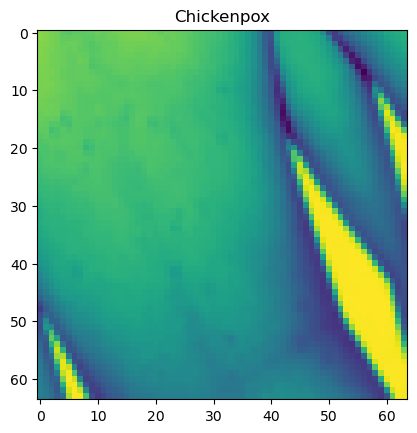

In [53]:
for images, labels in train_loader:
    pass

# Get one batch
images, labels = next(iter(train_loader))

indx=10
plt.imshow(images[indx].reshape(64,64))
plt.title(label_map[int(labels[indx].numpy())])

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs=10

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def accuracy(model, test_loader) :
    model.eval()
    with torch.no_grad():
        running_corrects=0
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        acc = running_corrects.double() / dataset_sizes["val"]
    return acc

In [55]:
from collections import Counter

train_classes = [dataset.targets[i] for i in train_data.indices]
print("train:",Counter(train_classes)) # if doesn' work: Counter(i.item() for i in train_classes)

test_classes = [dataset.targets[i] for i in test_data.indices]
print("Test:",Counter(test_classes)) # if doesn' work: Counter(i.item() for i in train_classes)

print("Total:",dict(Counter(test_data.dataset.targets)))

train: Counter({2: 427, 3: 405, 0: 273, 1: 227})
Test: Counter({2: 203, 3: 180, 0: 103, 1: 86})
Total: {0: 376, 1: 313, 2: 630, 3: 585}


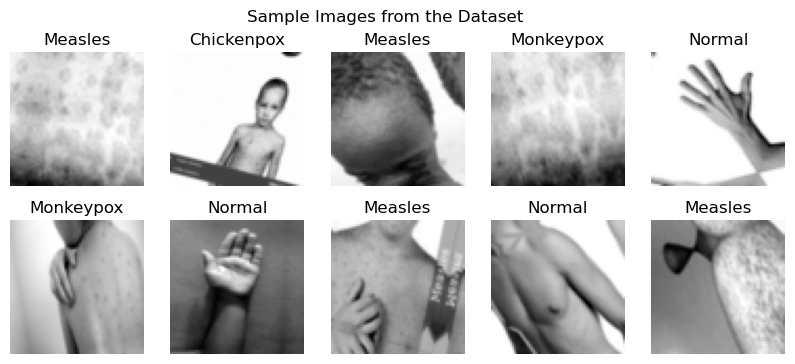

In [57]:
# Display a few sample images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle('Sample Images from the Dataset')
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(images[i * 5 + j].numpy().squeeze(), cmap='gray')
        axs[i, j].set_title(label_map[int(labels[i * 5 + j].numpy())])
        axs[i, j].axis('off')
plt.show()


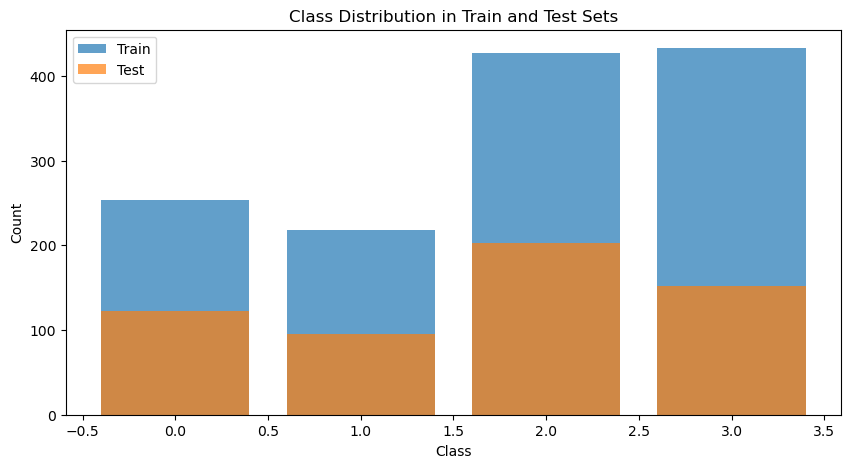

In [36]:
# Plot class distribution for train and test sets
train_classes = [dataset.targets[i] for i in train_data.indices]
test_classes = [dataset.targets[i] for i in test_data.indices]

plt.figure(figsize=(10, 5))
plt.bar(*zip(*Counter(train_classes).items()), label='Train', alpha=0.7)
plt.bar(*zip(*Counter(test_classes).items()), label='Test', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Train and Test Sets')
plt.legend()
plt.show()


['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}
Epoch 0/9
----------


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.0241 Acc: 0.5368
val Loss: 0.7857 Acc: 0.6696

Epoch 1/9
----------
train Loss: 0.6244 Acc: 0.7335
val Loss: 0.7201 Acc: 0.6836

Epoch 2/9
----------
train Loss: 0.4651 Acc: 0.7988
val Loss: 0.5274 Acc: 0.7570

Epoch 3/9
----------
train Loss: 0.3176 Acc: 0.8596
val Loss: 0.5395 Acc: 0.7850

Epoch 4/9
----------
train Loss: 0.3003 Acc: 0.8649
val Loss: 0.5083 Acc: 0.7937

Epoch 5/9
----------
train Loss: 0.2278 Acc: 0.9002
val Loss: 0.6130 Acc: 0.7622

Epoch 6/9
----------
train Loss: 0.1837 Acc: 0.9212
val Loss: 0.5819 Acc: 0.7552

Epoch 7/9
----------
train Loss: 0.1698 Acc: 0.9332
val Loss: 0.7305 Acc: 0.7483

Epoch 8/9
----------
train Loss: 0.1742 Acc: 0.9309
val Loss: 0.6437 Acc: 0.7745

Epoch 9/9
----------
train Loss: 0.1722 Acc: 0.9234
val Loss: 0.6925 Acc: 0.7762

Training complete in 8m 38s
Best val Acc: 0.793706
Test Accuracy: 79.37%


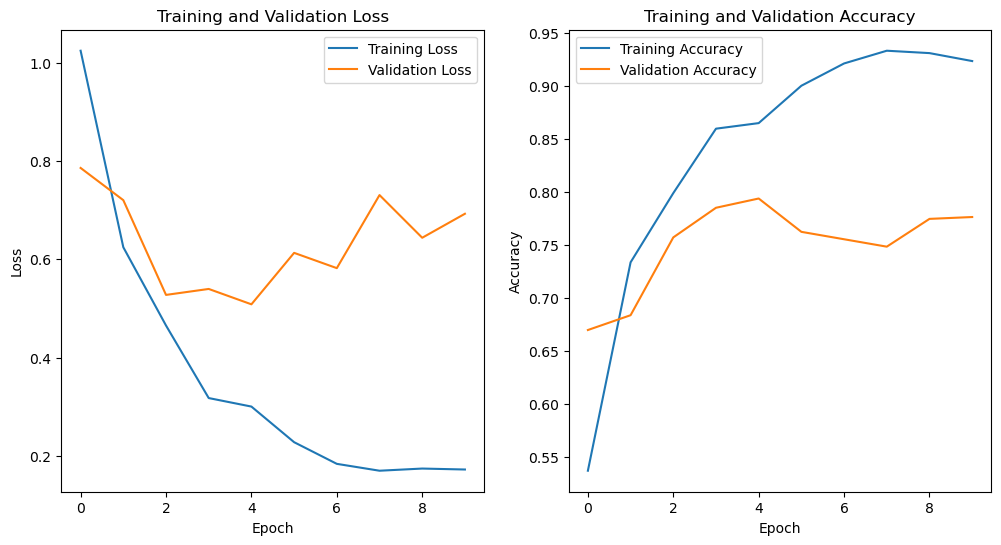

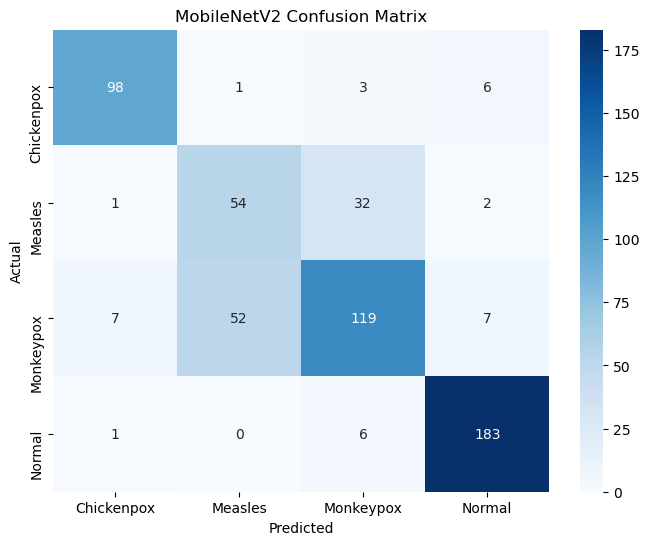

In [59]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the root path
root = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Data'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root, transform=data_transform)

# Display classes and class indices
print(dataset.classes)
print(dataset.class_to_idx)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch sizes for train and test data loaders
batch_size_train = 20
batch_size_test = 22

# Load data into batches via DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# Define label map and classes
label_map = {0: "Chickenpox", 1: "Measles", 2: "Monkeypox", 3: "Normal"}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders = {"train": train_loader, "val": test_loader}

dataset_sizes = {"train": len(train_loader.dataset), "val": len(test_loader.dataset)}

# Define device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the MobileNetV2 model
model_mobilenet = models.mobilenet_v2(pretrained=True)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, len(classes))
model_mobilenet = model_mobilenet.to(device)

# Save the model's state dictionary to the specified path
PATH_MOBILENET = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Streamlit/mobilenetmodel.pth'
os.makedirs(os.path.dirname(PATH_MOBILENET), exist_ok=True)
torch.save(model_mobilenet.state_dict(), PATH_MOBILENET)

# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# Train the model and get losses and accuracies
model_mobilenet, train_losses_mobilenet, val_losses_mobilenet, train_accs_mobilenet, val_accs_mobilenet = train_model(model_mobilenet,
                                                                                                                     nn.CrossEntropyLoss(),
                                                                                                                     optim.SGD(model_mobilenet.parameters(), lr=0.001, momentum=0.9),
                                                                                                                     lr_scheduler.StepLR(optim.SGD(model_mobilenet.parameters(), lr=0.001, momentum=0.9), step_size=7, gamma=0.1),
                                                                                                                     num_epochs=num_epochs)

# Save the trained model's state dictionary
torch.save(model_mobilenet.state_dict(), PATH_MOBILENET)

# Load the model for evaluation
loaded_model_mobilenet = models.mobilenet_v2(pretrained=True)
loaded_model_mobilenet.classifier[1] = nn.Linear(loaded_model_mobilenet.classifier[1].in_features, len(classes))
loaded_model_mobilenet = loaded_model_mobilenet.to(device)
loaded_model_mobilenet.load_state_dict(torch.load(PATH_MOBILENET, map_location=device))
loaded_model_mobilenet.eval()

# Test accuracy
test_accuracy_mobilenet = accuracy(loaded_model_mobilenet, test_loader)
print(f'Test Accuracy: {test_accuracy_mobilenet * 100:.2f}%')

# Plot loss and accuracy curves
def plot_loss_accuracy_mobilenet(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot loss and accuracy curves for MobileNetV2
plot_loss_accuracy_mobilenet(train_losses_mobilenet, val_losses_mobilenet, train_accs_mobilenet, val_accs_mobilenet)

# Plot confusion matrix
def plot_confusion_matrix_mobilenet(model, test_loader, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true += labels.cpu().numpy().tolist()
            y_pred += preds.cpu().numpy().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('MobileNetV2 Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the function to plot confusion matrix for MobileNetV2
plot_confusion_matrix_mobilenet(loaded_model_mobilenet, test_loader, classes)


['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 1.0570 Acc: 0.5480
val Loss: 0.8136 Acc: 0.6713

Epoch 1/9
----------
train Loss: 0.4950 Acc: 0.7988
val Loss: 0.6174 Acc: 0.7395

Epoch 2/9
----------
train Loss: 0.2731 Acc: 0.9054
val Loss: 0.5733 Acc: 0.7552

Epoch 3/9
----------
train Loss: 0.1963 Acc: 0.9377
val Loss: 0.7392 Acc: 0.7273

Epoch 4/9
----------
train Loss: 0.1566 Acc: 0.9459
val Loss: 0.6268 Acc: 0.7622

Epoch 5/9
----------
train Loss: 0.1125 Acc: 0.9670
val Loss: 0.5205 Acc: 0.8042

Epoch 6/9
----------
train Loss: 0.0705 Acc: 0.9857
val Loss: 0.5707 Acc: 0.8007

Epoch 7/9
----------
train Loss: 0.0719 Acc: 0.9797
val Loss: 0.6335 Acc: 0.7640

Epoch 8/9
----------
train Loss: 0.0513 Acc: 0.9887
val Loss: 0.5951 Acc: 0.7815

Epoch 9/9
----------
train Loss: 0.0395 Acc: 0.9925
val Loss: 0.6191 Acc: 0.7937

Training complete in 3m 36s
Best val Acc: 0.804196
ResNet Test Accuracy: 80.42%


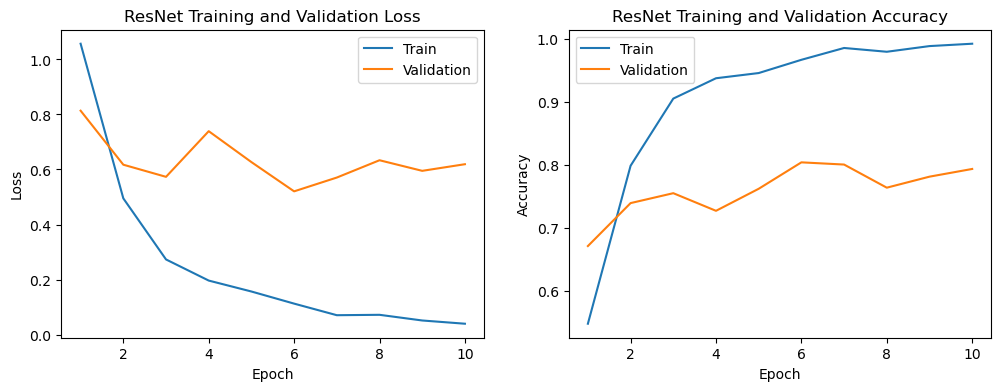

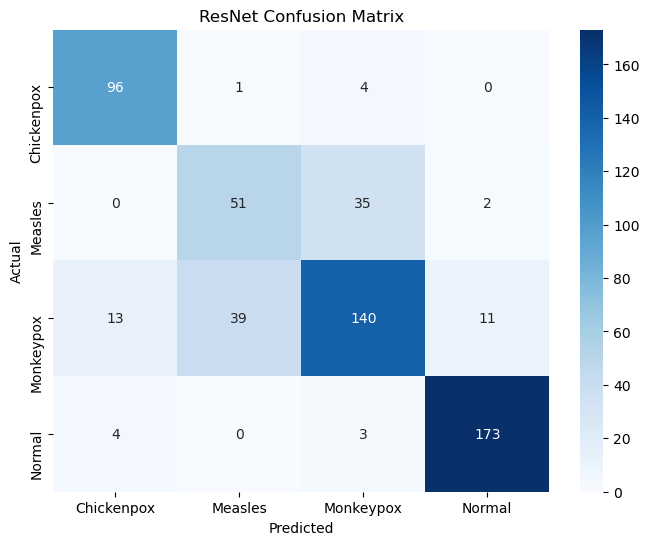

In [45]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the root path
root = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Data'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root, transform=data_transform)

# Display classes and class indices
print(dataset.classes)
print(dataset.class_to_idx)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch sizes for train and test data loaders
batch_size_train = 20
batch_size_test = 22

# Load data into batches via DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# Define label map and classes
label_map = {0: "Chickenpox", 1: "Measles", 2: "Monkeypox", 3: "Normal"}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders = {"train": train_loader, "val": test_loader}

dataset_sizes = {"train": len(train_loader.dataset), "val": len(test_loader.dataset)}

# Define device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup ResNet model
model_resnet = models.resnet18(pretrained=True)

# Save the model's state dictionary to the specified path
PATH_RESNET = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Streamlit/resnet18_model.pth'
os.makedirs(os.path.dirname(PATH_RESNET), exist_ok=True)
torch.save(model_resnet.state_dict(), PATH_RESNET)

# Modify the fully connected layer for the number of classes
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(classes))
model_resnet = model_resnet.to(device)

# Define loss function and optimizer
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=1, gamma=0.9)

# Train the model and get losses and accuracies
model_resnet, train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet = train_model(model_resnet, criterion_resnet,
                                                                                                       optimizer_resnet,
                                                                                                       exp_lr_scheduler_resnet,
                                                                                                       num_epochs=10)

# Save the trained model's state dictionary
torch.save(model_resnet.state_dict(), PATH_RESNET)

# Load the model
loaded_model_resnet = models.resnet18(pretrained=True)
num_ftrs_resnet = loaded_model_resnet.fc.in_features
loaded_model_resnet.fc = nn.Linear(num_ftrs_resnet, len(classes))
loaded_model_resnet = loaded_model_resnet.to(device)
loaded_model_resnet.load_state_dict(torch.load(PATH_RESNET, map_location=device))
loaded_model_resnet.eval()

# Test the model accuracy
def accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        running_corrects = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_corrects += (preds == labels).sum().item()

        acc = running_corrects / total

    return acc

# Calculate and print test accuracy
test_accuracy_resnet = accuracy(loaded_model_resnet, test_loader)
print(f'ResNet Test Accuracy: {test_accuracy_resnet * 100:.2f}%')

# Plot loss and accuracy over epochs for ResNet
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses, label='Validation')
    plt.title(f'{title} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train')
    plt.plot(epochs, val_accs, label='Validation')
    plt.title(f'{title} Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call this function after training
plot_loss_accuracy(train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet, 'ResNet')

# Plot confusion matrix for ResNet
def plot_confusion_matrix_resnet(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('ResNet Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the function to plot confusion matrix for ResNet
plot_confusion_matrix_resnet(loaded_model_resnet, test_loader, classes)


['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.2394 Acc: 0.4902
val Loss: 1.1236 Acc: 0.4843

Epoch 1/9
----------
train Loss: 0.9292 Acc: 0.6074
val Loss: 1.1675 Acc: 0.4965

Epoch 2/9
----------
train Loss: 0.8650 Acc: 0.6329
val Loss: 0.9379 Acc: 0.5892

Epoch 3/9
----------
train Loss: 0.7638 Acc: 0.6787
val Loss: 0.8528 Acc: 0.6206

Epoch 4/9
----------
train Loss: 0.6311 Acc: 0.7252
val Loss: 0.9120 Acc: 0.5857

Epoch 5/9
----------
train Loss: 0.5612 Acc: 0.7477
val Loss: 0.7272 Acc: 0.6888

Epoch 6/9
----------
train Loss: 0.4599 Acc: 0.8071
val Loss: 0.7148 Acc: 0.6871

Epoch 7/9
----------
train Loss: 0.4621 Acc: 0.7950
val Loss: 0.7753 Acc: 0.6346

Epoch 8/9
----------
train Loss: 0.3542 Acc: 0.8483
val Loss: 0.9472 Acc: 0.6381

Epoch 9/9
----------
train Loss: 0.3853 Acc: 0.8341
val Loss: 0.7771 Acc: 0.6626

Training complete in 3m 34s
Best val Acc: 0.688811
AlexNet Test Accuracy: 68.88%


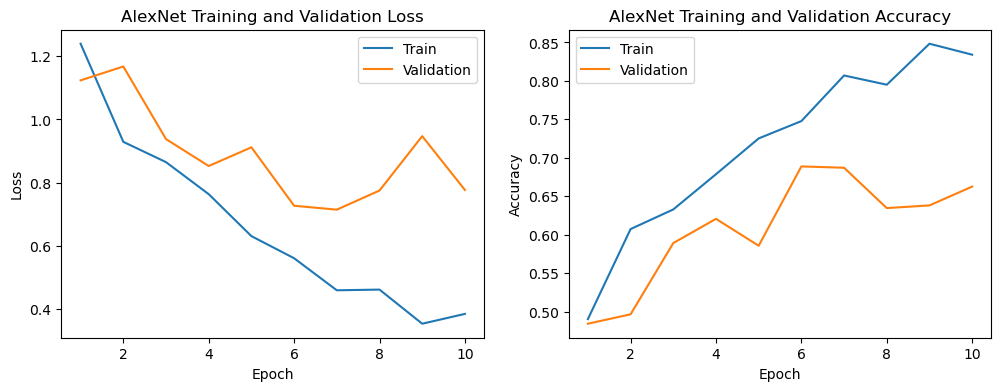

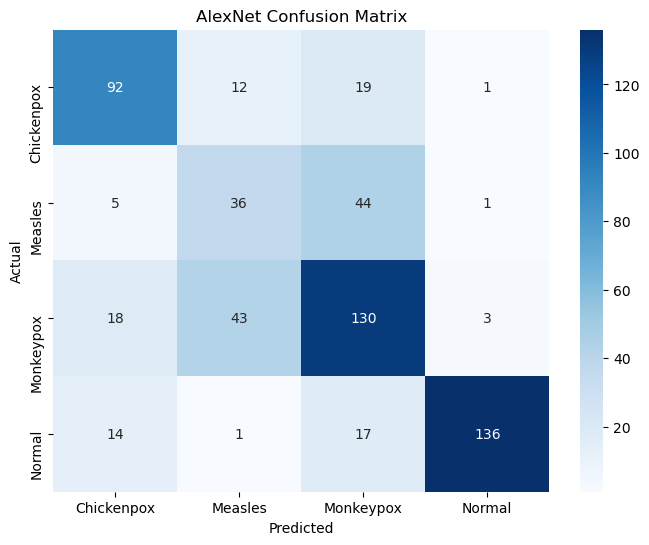

In [46]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the root path
root = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Data'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root, transform=data_transform)

# Display classes and class indices
print(dataset.classes)
print(dataset.class_to_idx)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch sizes for train and test data loaders
batch_size_train = 20
batch_size_test = 22

# Load data into batches via DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# Define label map and classes
label_map = {0: "Chickenpox", 1: "Measles", 2: "Monkeypox", 3: "Normal"}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders = {"train": train_loader, "val": test_loader}

dataset_sizes = {"train": len(train_loader.dataset), "val": len(test_loader.dataset)}

# Define device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the AlexNet model
model_alexnet = models.alexnet(pretrained=True)
model_alexnet.classifier[6] = nn.Linear(4096, len(classes))
model_alexnet = model_alexnet.to(device)

# Save the model's state dictionary to the specified path
PATH_ALEXNET = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Streamlit/alexnetmodel.pth'
os.makedirs(os.path.dirname(PATH_ALEXNET), exist_ok=True)
torch.save(model_alexnet.state_dict(), PATH_ALEXNET)

# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# Train the model and get losses and accuracies
model_alexnet, train_losses_alexnet, val_losses_alexnet, train_accs_alexnet, val_accs_alexnet = train_model(model_alexnet,
                                                                                                           nn.CrossEntropyLoss(),
                                                                                                           optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9),
                                                                                                           lr_scheduler.StepLR(optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9), step_size=7, gamma=0.1),
                                                                                                           num_epochs=10)

# Save the trained model's state dictionary
torch.save(model_alexnet.state_dict(), PATH_ALEXNET)

# Load the model
loaded_model_alexnet = models.alexnet(pretrained=True)
loaded_model_alexnet.classifier[6] = nn.Linear(4096, len(classes))
loaded_model_alexnet = loaded_model_alexnet.to(device)
loaded_model_alexnet.load_state_dict(torch.load(PATH_ALEXNET, map_location=device))
loaded_model_alexnet.eval()

# Test the model accuracy
test_accuracy_alexnet = accuracy(loaded_model_alexnet, test_loader)
print(f'AlexNet Test Accuracy: {test_accuracy_alexnet * 100:.2f}%')

# Plot loss and accuracy over epochs for AlexNet
plot_loss_accuracy(train_losses_alexnet, val_losses_alexnet, train_accs_alexnet, val_accs_alexnet, 'AlexNet')

# Plot confusion matrix for AlexNet
def plot_confusion_matrix_alexnet(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('AlexNet Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the function to plot confusion matrix for AlexNet
plot_confusion_matrix_alexnet(loaded_model_alexnet, test_loader, classes)


['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.0014 Acc: 0.5788
val Loss: 0.7511 Acc: 0.6888

Epoch 1/9
----------
train Loss: 0.4967 Acc: 0.7823
val Loss: 0.5017 Acc: 0.7535

Epoch 2/9
----------
train Loss: 0.2836 Acc: 0.8979
val Loss: 0.4585 Acc: 0.7815

Epoch 3/9
----------
train Loss: 0.1615 Acc: 0.9414
val Loss: 0.4876 Acc: 0.7937

Epoch 4/9
----------
train Loss: 0.1252 Acc: 0.9565
val Loss: 0.4999 Acc: 0.7972

Epoch 5/9
----------
train Loss: 0.0784 Acc: 0.9752
val Loss: 0.6615 Acc: 0.7727

Epoch 6/9
----------
train Loss: 0.0554 Acc: 0.9835
val Loss: 0.6092 Acc: 0.7815

Epoch 7/9
----------
train Loss: 0.0495 Acc: 0.9835
val Loss: 0.5840 Acc: 0.7920

Epoch 8/9
----------
train Loss: 0.0371 Acc: 0.9917
val Loss: 0.6358 Acc: 0.8007

Epoch 9/9
----------
train Loss: 0.0356 Acc: 0.9932
val Loss: 0.6278 Acc: 0.7920

Training complete in 17m 47s
Best val Acc: 0.800699
DenseNet161 Test Accuracy: 80.07%


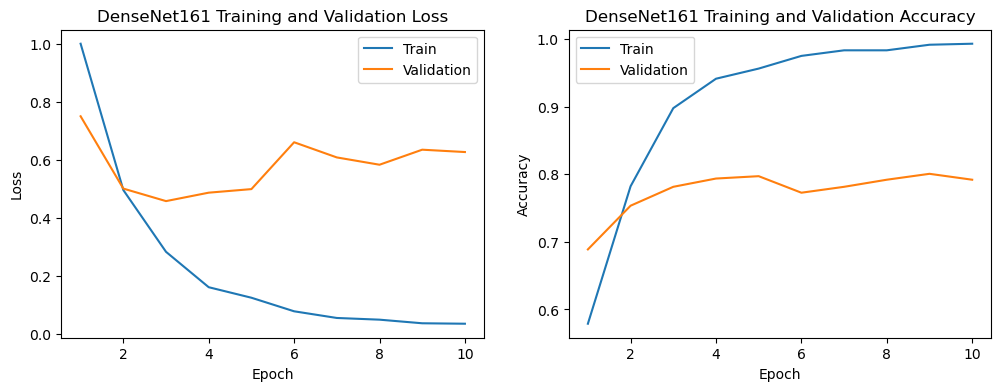

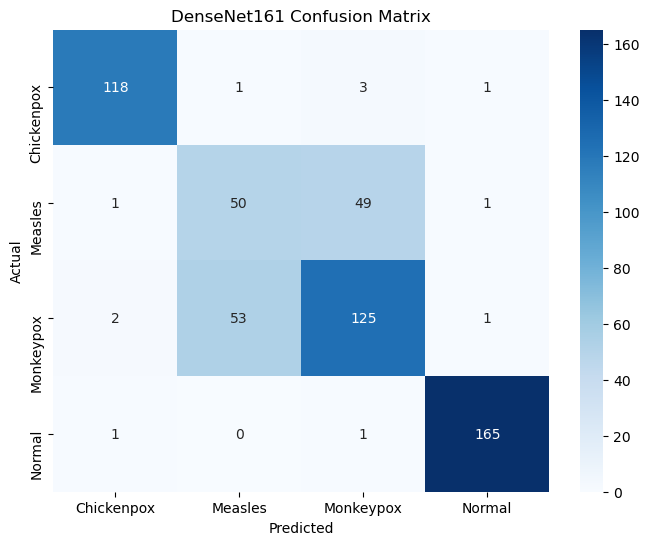

In [47]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the root path
root = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Data'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root, transform=data_transform)

# Display classes and class indices
print(dataset.classes)
print(dataset.class_to_idx)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch sizes for train and test data loaders
batch_size_train = 20
batch_size_test = 22

# Load data into batches via DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# Define label map and classes
label_map = {0: "Chickenpox", 1: "Measles", 2: "Monkeypox", 3: "Normal"}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders = {"train": train_loader, "val": test_loader}

dataset_sizes = {"train": len(train_loader.dataset), "val": len(test_loader.dataset)}

# Define device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the DenseNet161 model
model_densenet = models.densenet161(pretrained=True)
num_classes = len(classes)
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, num_classes)
model_densenet = model_densenet.to(device)

# Save the model's state dictionary to the specified path
PATH_DENSENET = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Streamlit/densenet161model.pth'
os.makedirs(os.path.dirname(PATH_DENSENET), exist_ok=True)
torch.save(model_densenet.state_dict(), PATH_DENSENET)

# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# Train the model and get losses and accuracies
model_densenet, train_losses_densenet, val_losses_densenet, train_accs_densenet, val_accs_densenet = train_model(model_densenet,
                                                                                                               nn.CrossEntropyLoss(),
                                                                                                               optim.SGD(model_densenet.parameters(), lr=0.001, momentum=0.9),
                                                                                                               lr_scheduler.StepLR(optim.SGD(model_densenet.parameters(), lr=0.001, momentum=0.9), step_size=7, gamma=0.1),
                                                                                                               num_epochs=10)

# Save the trained model's state dictionary
torch.save(model_densenet.state_dict(), PATH_DENSENET)

# Load the model
loaded_model_densenet = models.densenet161(pretrained=True)
loaded_model_densenet.classifier = nn.Linear(num_ftrs, num_classes)
loaded_model_densenet = loaded_model_densenet.to(device)
loaded_model_densenet.load_state_dict(torch.load(PATH_DENSENET, map_location=device))
loaded_model_densenet.eval()

# Test the model accuracy
test_accuracy_densenet = accuracy(loaded_model_densenet, test_loader)
print(f'DenseNet161 Test Accuracy: {test_accuracy_densenet * 100:.2f}%')

# Plot loss and accuracy over epochs for DenseNet161
plot_loss_accuracy(train_losses_densenet, val_losses_densenet, train_accs_densenet, val_accs_densenet, 'DenseNet161')

# Plot confusion matrix for DenseNet161
def plot_confusion_matrix_densenet(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('DenseNet161 Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the function to plot confusion matrix for DenseNet161
plot_confusion_matrix_densenet(loaded_model_densenet, test_loader, classes)


['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}
Epoch 0/9
----------


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Adupa vivek\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value

train Loss: 1.3688 Acc: 0.3671
val Loss: 1.3829 Acc: 0.1941

Epoch 1/9
----------
train Loss: 1.3239 Acc: 0.3423
val Loss: 1.3808 Acc: 0.2010

Epoch 2/9
----------
train Loss: 1.2232 Acc: 0.4362
val Loss: 1.1612 Acc: 0.5175

Epoch 3/9
----------
train Loss: 1.1345 Acc: 0.5323
val Loss: 0.9737 Acc: 0.6154

Epoch 4/9
----------
train Loss: 1.0117 Acc: 0.5826
val Loss: 0.9350 Acc: 0.6399

Epoch 5/9
----------
train Loss: 0.9560 Acc: 0.6059
val Loss: 0.8951 Acc: 0.6381

Epoch 6/9
----------
train Loss: 0.8572 Acc: 0.6351
val Loss: 0.9692 Acc: 0.5962

Epoch 7/9
----------
train Loss: 0.8048 Acc: 0.6554
val Loss: 0.7385 Acc: 0.7045

Epoch 8/9
----------
train Loss: 0.7557 Acc: 0.6794
val Loss: 0.7899 Acc: 0.6713

Epoch 9/9
----------
train Loss: 0.6474 Acc: 0.7140
val Loss: 0.7437 Acc: 0.6993

Training complete in 1m 47s
Best val Acc: 0.704545
Test Accuracy: 70.45%


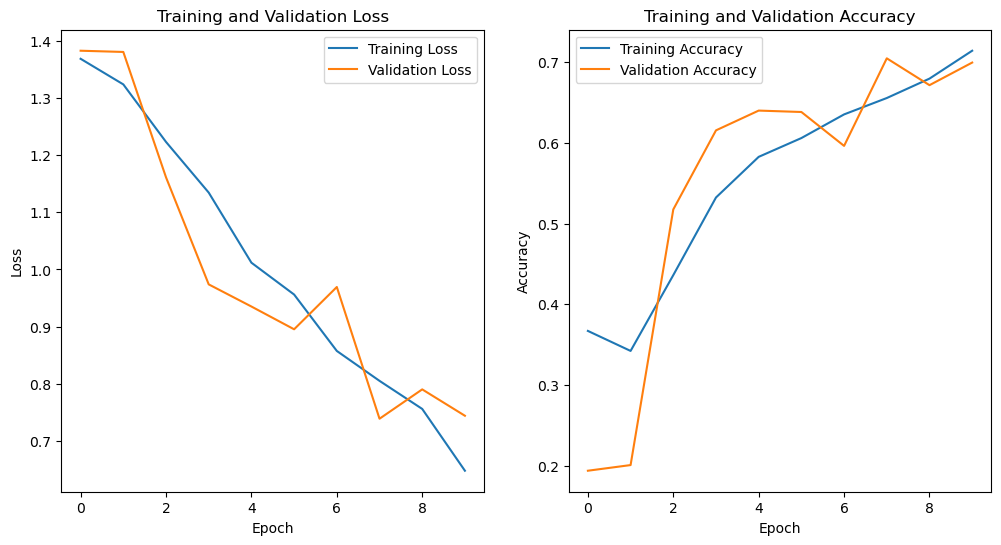

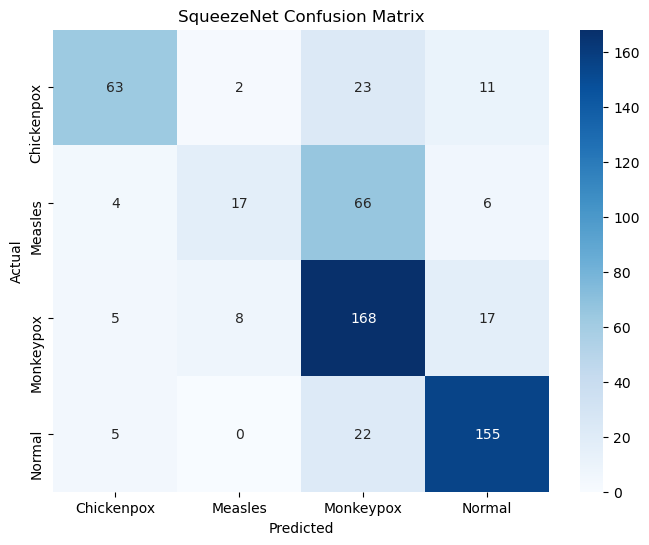

In [48]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the root path
root = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Data'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root, transform=data_transform)

# Display classes and class indices
print(dataset.classes)
print(dataset.class_to_idx)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch sizes for train and test data loaders
batch_size_train = 20
batch_size_test = 22

# Load data into batches via DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# Define label map and classes
label_map = {0: "Chickenpox", 1: "Measles", 2: "Monkeypox", 3: "Normal"}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders = {"train": train_loader, "val": test_loader}

dataset_sizes = {"train": len(train_loader.dataset), "val": len(test_loader.dataset)}

# Define device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the SqueezeNet model
model_squeezenet = models.squeezenet1_1(pretrained=True)
model_squeezenet.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1, 1), stride=(1, 1))
model_squeezenet = model_squeezenet.to(device)

# Save the model's state dictionary to the specified path
PATH_SQUEEZENET = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Streamlit/squeezenetmodel.pth'
os.makedirs(os.path.dirname(PATH_SQUEEZENET), exist_ok=True)
torch.save(model_squeezenet.state_dict(), PATH_SQUEEZENET)

# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# Train the model and get losses and accuracies
model_squeezenet, train_losses_squeezenet, val_losses_squeezenet, train_accs_squeezenet, val_accs_squeezenet = train_model(model_squeezenet,
                                                                                                                           nn.CrossEntropyLoss(),
                                                                                                                           optim.SGD(model_squeezenet.parameters(), lr=0.001, momentum=0.9),
                                                                                                                           lr_scheduler.StepLR(optim.SGD(model_squeezenet.parameters(), lr=0.001, momentum=0.9), step_size=7, gamma=0.1),
                                                                                                                           num_epochs=num_epochs)

# Save the trained model's state dictionary
torch.save(model_squeezenet.state_dict(), PATH_SQUEEZENET)

# Load the model for evaluation
loaded_model_squeezenet = models.squeezenet1_1(pretrained=True)
loaded_model_squeezenet.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1, 1), stride=(1, 1))
loaded_model_squeezenet = loaded_model_squeezenet.to(device)
loaded_model_squeezenet.load_state_dict(torch.load(PATH_SQUEEZENET, map_location=device))
loaded_model_squeezenet.eval()

# Test accuracy
def accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    return acc

# Print the accuracy on the test set
test_accuracy_squeezenet = accuracy(loaded_model_squeezenet, test_loader)
print(f'Test Accuracy: {test_accuracy_squeezenet * 100:.2f}%')

# Plot loss and accuracy curves
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot loss and accuracy curves for SqueezeNet
plot_loss_accuracy(train_losses_squeezenet, val_losses_squeezenet, train_accs_squeezenet, val_accs_squeezenet)

# Plot confusion matrix
def plot_confusion_matrix_squeezenet(model, test_loader, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true += labels.cpu().numpy().tolist()
            y_pred += preds.cpu().numpy().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('SqueezeNet Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the function to plot confusion matrix for SqueezeNet
plot_confusion_matrix_squeezenet(loaded_model_squeezenet, test_loader, classes)


['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.0438 Acc: 0.5556
val Loss: 0.7568 Acc: 0.6923

Epoch 1/9
----------
train Loss: 0.6136 Acc: 0.7222
val Loss: 0.5931 Acc: 0.7378

Epoch 2/9
----------
train Loss: 0.4130 Acc: 0.8033
val Loss: 0.5804 Acc: 0.7255

Epoch 3/9
----------
train Loss: 0.3337 Acc: 0.8363
val Loss: 0.5379 Acc: 0.7535

Epoch 4/9
----------
train Loss: 0.2732 Acc: 0.8604
val Loss: 0.4833 Acc: 0.7640

Epoch 5/9
----------
train Loss: 0.2239 Acc: 0.8889
val Loss: 0.7600 Acc: 0.7115

Epoch 6/9
----------
train Loss: 0.2684 Acc: 0.8656
val Loss: 0.6381 Acc: 0.7552

Epoch 7/9
----------
train Loss: 0.2276 Acc: 0.8971
val Loss: 0.6146 Acc: 0.7535

Epoch 8/9
----------
train Loss: 0.1640 Acc: 0.9339
val Loss: 0.6119 Acc: 0.7832

Epoch 9/9
----------
train Loss: 0.1073 Acc: 0.9497
val Loss: 0.6435 Acc: 0.7885

Training complete in 20m 20s
Best val Acc: 0.788462
Test Accuracy: 78.85%


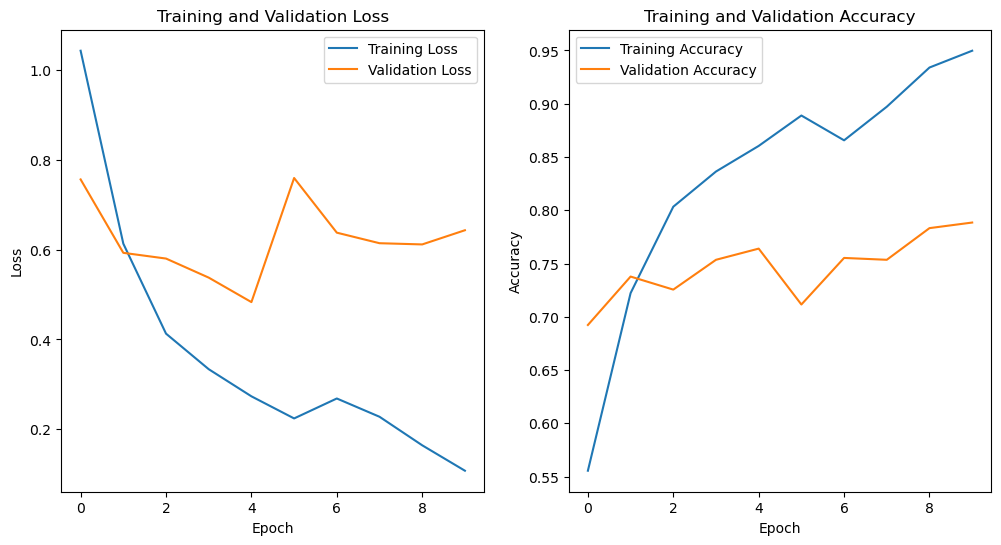

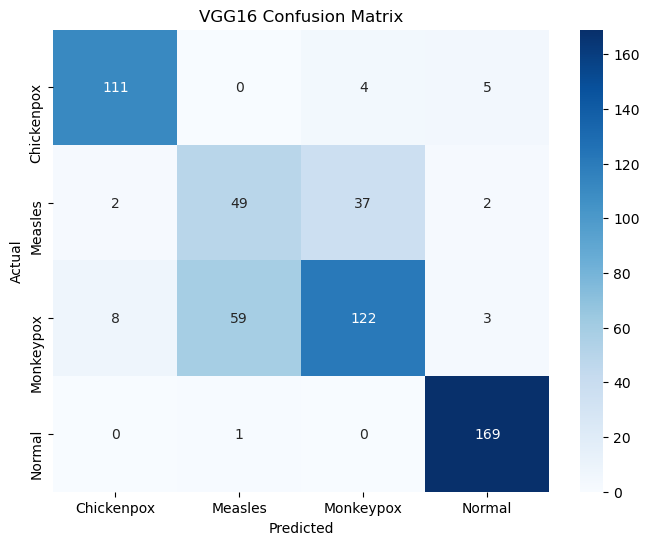

In [49]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the root path
root = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Data'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root, transform=data_transform)

# Display classes and class indices
print(dataset.classes)
print(dataset.class_to_idx)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch sizes for train and test data loaders
batch_size_train = 20
batch_size_test = 22

# Load data into batches via DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# Define label map and classes
label_map = {0: "Chickenpox", 1: "Measles", 2: "Monkeypox", 3: "Normal"}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders = {"train": train_loader, "val": test_loader}

dataset_sizes = {"train": len(train_loader.dataset), "val": len(test_loader.dataset)}

# Define device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the VGG16 model
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier[6] = nn.Linear(4096, len(classes))
model_vgg16 = model_vgg16.to(device)

# Save the model's state dictionary to the specified path
PATH_VGG16 = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Streamlit/vgg16model.pth'
os.makedirs(os.path.dirname(PATH_VGG16), exist_ok=True)
torch.save(model_vgg16.state_dict(), PATH_VGG16)

# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# Train the model and get losses and accuracies
model_vgg16, train_losses_vgg16, val_losses_vgg16, train_accs_vgg16, val_accs_vgg16 = train_model(model_vgg16,
                                                                                                  nn.CrossEntropyLoss(),
                                                                                                  optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9),
                                                                                                  lr_scheduler.StepLR(optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9), step_size=7, gamma=0.1),
                                                                                                  num_epochs=num_epochs)

# Save the trained model's state dictionary
torch.save(model_vgg16.state_dict(), PATH_VGG16)

# Load the model for evaluation
loaded_model_vgg16 = models.vgg16(pretrained=True)
loaded_model_vgg16.classifier[6] = nn.Linear(4096, len(classes))
loaded_model_vgg16 = loaded_model_vgg16.to(device)
loaded_model_vgg16.load_state_dict(torch.load(PATH_VGG16, map_location=device))
loaded_model_vgg16.eval()

# Test accuracy
test_accuracy_vgg16 = accuracy(loaded_model_vgg16, test_loader)
print(f'Test Accuracy: {test_accuracy_vgg16 * 100:.2f}%')

# Plot loss and accuracy curves
def plot_loss_accuracy_vgg16(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot loss and accuracy curves for VGG16
plot_loss_accuracy_vgg16(train_losses_vgg16, val_losses_vgg16, train_accs_vgg16, val_accs_vgg16)

# Plot confusion matrix
def plot_confusion_matrix_vgg16(model, test_loader, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true += labels.cpu().numpy().tolist()
            y_pred += preds.cpu().numpy().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('VGG16 Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the function to plot confusion matrix for VGG16
plot_confusion_matrix_vgg16(loaded_model_vgg16, test_loader, classes)


['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adupa vivek\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------


c:\Users\Adupa vivek\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.1888 Acc: 0.5270
val Loss: 1.9175 Acc: 0.4580

Epoch 1/9
----------
train Loss: 1.3070 Acc: 0.6134
val Loss: 2.2690 Acc: 0.4878

Epoch 2/9
----------
train Loss: 1.2204 Acc: 0.5826
val Loss: 1.1939 Acc: 0.5175

Epoch 3/9
----------
train Loss: 0.9071 Acc: 0.6486
val Loss: 0.8161 Acc: 0.6521

Epoch 4/9
----------
train Loss: 0.7232 Acc: 0.7027
val Loss: 0.9025 Acc: 0.5944

Epoch 5/9
----------
train Loss: 0.6627 Acc: 0.7417
val Loss: 1.1769 Acc: 0.5682

Epoch 6/9
----------
train Loss: 0.7210 Acc: 0.7110
val Loss: 0.8189 Acc: 0.6346

Epoch 7/9
----------
train Loss: 0.5637 Acc: 0.7583
val Loss: 0.7209 Acc: 0.6853

Epoch 8/9
----------
train Loss: 0.3844 Acc: 0.8281
val Loss: 0.7273 Acc: 0.7168

Epoch 9/9
----------
train Loss: 0.3431 Acc: 0.8461
val Loss: 0.7547 Acc: 0.7290

Training complete in 6m 54s
Best val Acc: 0.729021


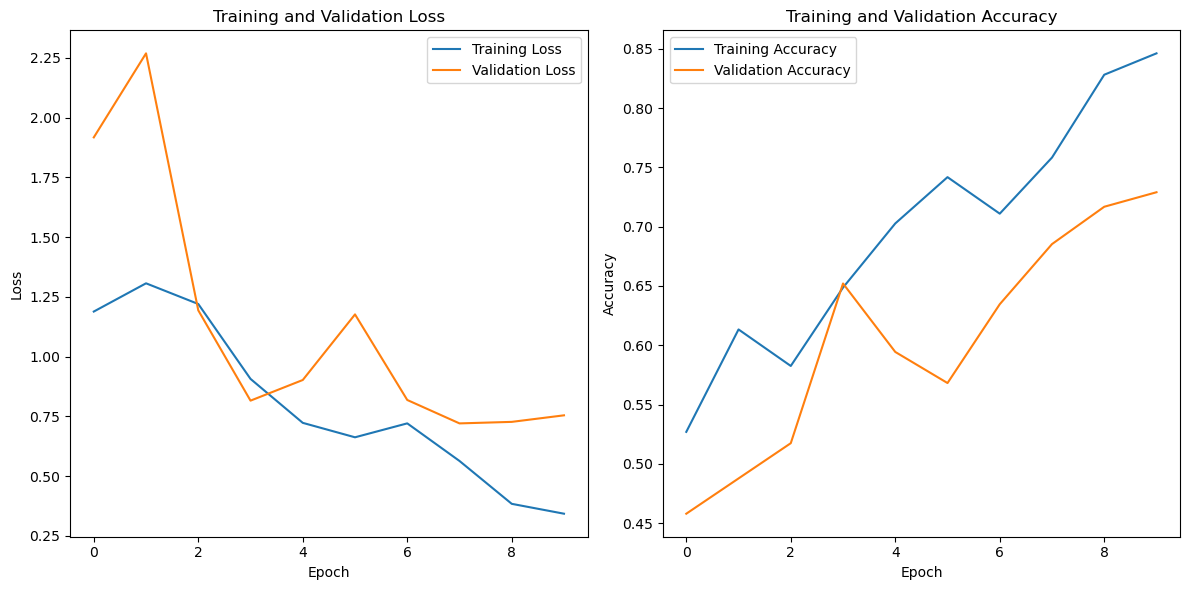

In [28]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import matplotlib.pyplot as plt
from collections import Counter

# Define the root path
root = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Data'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = torchvision.datasets.ImageFolder(root, transform=data_transform)

# Display classes and class indices
print(dataset.classes)
print(dataset.class_to_idx)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch sizes for train and test data loaders
batch_size_train = 20
batch_size_test = 22

# Load data into batches via DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# Define label map and classes
label_map = {0: "Chickenpox", 1: "Measles", 2: "Monkeypox", 3: "Normal"}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders = {"train": train_loader, "val": test_loader}

dataset_sizes = {"train": len(train_loader.dataset), "val": len(test_loader.dataset)}

# Define device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the ResNet model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))  # Modify the fc layer
model = model.to(device)

# Save the model's state dictionary to the specified path
PATH = 'D:/MY PROJECTS/project/-Monkeypox-Detection-master (2)/-Monkeypox-Detection-master/Monkeypox/Streamlit/resnet18_netmodel.pth'
os.makedirs(os.path.dirname(PATH), exist_ok=True)
torch.save(model.state_dict(), PATH)

# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    # Plotting the training progress
    plot_training_progress(train_losses, val_losses, train_accs, val_accs)

    return model

# Function to plot training progress
def plot_training_progress(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
num_epochs = 10
trained_model = train_model(model, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=0.001, momentum=0.98),
                             lr_scheduler.StepLR(optim.SGD(model.parameters(), lr=0.001, momentum=0.98), step_size=1000, gamma=0.1),
                             num_epochs)

